# Mini project 4 - generative model

Authors:
- Patryk Będkowski
- Kamil Sulkowski

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(500)
    torch.cuda.manual_seed_all(500)

torch.manual_seed(500)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [4]:
BATCH_SIZE = 16

## Data preprocessing

In [29]:
raw_dataset_loader = torchvision.datasets.ImageFolder("data/", transform=transforms.ToTensor())

In [30]:
n_channels = 3

inp_dataloader = torch.utils.data.DataLoader(raw_dataset_loader, batch_size=128, shuffle=False)
class_sums_sq = {}
class_stds = {}
class_means = {}
class_counts = {}

for index, data in enumerate(inp_dataloader):
    data_img, data_class = data[0], data[1]
    for i in range(data_img.shape[0]):
        class_label = raw_dataset_loader.classes[data_class[i]]
        if class_label not in class_sums_sq:
            class_sums_sq[class_label] = [0.0] * n_channels
            class_stds[class_label] = [0.0] * n_channels
            class_means[class_label] = [0.0] * n_channels
            class_counts[class_label] = [0.0] * n_channels

        for ch_ind in range(n_channels):
            data_img_ch = data_img[i, ch_ind]
            class_counts[class_label][ch_ind] += np.prod(data_img_ch.shape)
            class_sums_sq[class_label][ch_ind] += ((data_img_ch - class_means[class_label][ch_ind]) ** 2).sum()
            class_means[class_label][ch_ind] += data_img_ch.sum()

for class_label in class_sums_sq:
    for ch_ind in range(n_channels):
        class_means[class_label][ch_ind] /= class_counts[class_label][ch_ind]
        class_stds[class_label][ch_ind] = np.sqrt(class_sums_sq[class_label][ch_ind] / class_counts[class_label][ch_ind]).item()
        class_means[class_label][ch_ind] = class_means[class_label][ch_ind].item()

In [40]:
class_transforms = {}

for class_label in class_means:
    mean = class_means[class_label]
    std = class_stds[class_label]
    transform = transforms.Normalize(mean=mean, std=std)
    class_transforms[class_label] = transform

In [41]:
transform = transforms.Compose([
    transforms.ToTensor(),
    class_transforms
])

In [42]:
preprocessed_data = torchvision.datasets.ImageFolder("data/", transform=transform)

In [43]:
loader = torch.utils.data.DataLoader(
    preprocessed_data,
    BATCH_SIZE,
    shuffle=True
)

## VAE Model

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(Encoder, self).__init__()

        # 32x32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2)
        self.bn5 = nn.BatchNorm2d(256)
        # 5x5
        self.fc_1 = nn.Linear(5*5*256, 3200)
        self.fc_2 = nn.Linear(3200, 1024)

        self.fc_mean = nn.Linear(1024, latent_dim)
        self.fc_var = nn.Linear(1024, latent_dim)

    def forward(self, x):
        x=self.bn1(F.relu(self.conv1(x)))
        x=self.bn2(F.relu(self.conv2(x)))
        x=self.bn3(F.relu(self.conv3(x)))
        x=self.bn4(F.relu(self.conv4(x)))
        x=self.bn5(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        mean = self.fc_mean(x)
        log_var = torch.tanh(self.fc_var(x))

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 5*5*16),
            nn.ReLU(),
            nn.Linear(5*5*16, 5*5*64)
        )
        # 5x5
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)

        self.convt1 = nn.ConvTranspose2d(in_channels=128, out_channels=96, kernel_size=2)
        self.bnt1 = nn.BatchNorm2d(96)

        self.convt2 = nn.ConvTranspose2d(in_channels=96, out_channels=64, kernel_size=2)
        self.bnt2 = nn.BatchNorm2d(64)

        self.convt3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2)
        self.bnt3 = nn.BatchNorm2d(32)

        self.convt4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
        self.bnt4 = nn.BatchNorm2d(16)

        self.convt5 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=2, stride=2)
        # 32x32
        self.lrelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], 64, 5, 5)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bnt1(self.lrelu(self.convt1(x)))
        x = self.bnt2(self.lrelu(self.convt2(x)))
        x = self.bnt3(self.lrelu(self.convt3(x)))
        x = self.bnt4(self.lrelu(self.convt4(x)))
        x = self.convt5(x)
        
        return x


class VAE(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparametrization_trick(self, mean, std):
        z = torch.randn_like(mean).to(device) * std + mean
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparametrization_trick(mean, torch.exp(0.5*log_var))
        x = self.decoder(z)
        return x, mean, log_var

## Loss function

In [8]:
def vae_loss(
    x_out: torch.tensor, x: torch.tensor, mean: torch.tensor, log_var: torch.tensor
) -> torch.tensor:
    mse = nn.functional.mse_loss(x_out, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return mse + kld

## Training

In [9]:
LATENT_DIM = 128
LR = 0.0003

In [10]:
def train(model, optimizer, loader, criterion=vae_loss, epochs=10):
    for epoch in range(epochs):
        losses_epoch = []
        for x, _ in loader:
            x = x.to(device)
            optimizer.zero_grad()
            out, means, log_var = model(x)
            loss = criterion(out, x, means, log_var)
            loss.backward()
            losses_epoch.append(loss.item())
            optimizer.step()
        print(f'[{epoch+1}/{epochs}] loss: {np.mean(np.array(losses_epoch)).item():.3}')

In [11]:
my_vae = VAE(LATENT_DIM).to(device)
optimizer = torch.optim.Adam(my_vae.parameters(), LR)

In [12]:
train(
    model=my_vae,
    optimizer=optimizer,
    loader=loader,
    epochs=20
)

[1/20] loss: 2.33e+03


KeyboardInterrupt: 

## Example generation from a training example

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(5,5))
img = next(iter(loader))[0].to(device)
axs[0].axis('off')
axs[0].imshow(my_vae(img)[0][0].permute(1, 2, 0).cpu().detach())
axs[0].set_title("vae")
axs[1].axis('off')
axs[1].imshow(img[0].permute(1, 2, 0).cpu().detach())
axs[1].set_title("real")
plt.show()

## Generation from random noise

In [198]:
def generate_random_images(model, n_imgs: int = 1000, img_shape: tuple = (3, 32, 32)
) -> torch.tensor:
    imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    assert imgs.shape == tuple((n_imgs, *img_shape))
    return imgs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


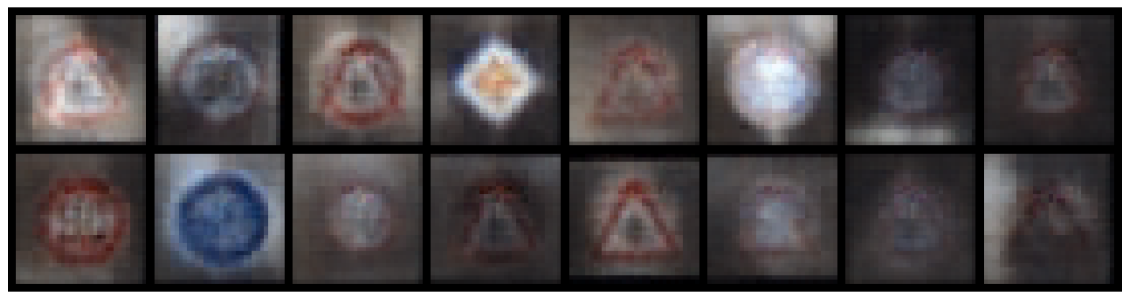

In [340]:
imgs = generate_random_images(my_vae, 16)
grid = torchvision.utils.make_grid(imgs)
grid = grid.permute(1, 2, 0).cpu().detach()
plt.figure(figsize=(20, 10))
plt.imshow(grid)
plt.axis('off')
plt.show()

## Save generated images to file

In [202]:
generated_images = generate_random_images(my_vae)
torch.save(generated_images.cpu().detach(), "piatek_Bedkowski_Sulkowski.pt")